In [1]:
import pandas as pd
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import OrderedDict

In [3]:
import numpy as np

exp_train_list = [np.load(f"/home/CAMPUS/hdasari/apebench_experiments/ks_1d/data/KS_1d_train_data_exp{i}.npy") for i in range(1, 7)]
exp_test_list = [np.load(f"/home/CAMPUS/hdasari/apebench_experiments/ks_1d/data/KS_1d_test_data_exp{i}.npy") for i in range(1, 7)]

train_split = []
val_split = []
test_split = []

for data, data_test in zip(exp_train_list, exp_test_list):
    num_samples = data.shape[0]
    split_index = int(num_samples * 0.75)
    train_split.append(data[:split_index])
    val_split.append(data[split_index:])  # 10% as validation
    test_split.append(data_test)  # Test data is not split


ks_train = np.stack(train_split, axis=0)  # 6 , 450 
ks_val = np.stack(val_split, axis=0)      # 6 , 50
ks_test = np.stack(test_split, axis=0)    # 6 , 20

print("Train split shape:", ks_train.shape)
print("Validation split shape:", ks_val.shape)
print("Test split shape:", ks_test.shape)


Train split shape: (6, 375, 43, 1, 160)
Validation split shape: (6, 125, 43, 1, 160)
Test split shape: (6, 20, 43, 1, 160)


# Dataset class

- the below KSDataset make a data based on unrolled training, that means 
for predicting x(t+seq) input is x(t),x(t+1),........upto x(t+seq)
- if we want the model to predict x(t+1) given x(t), just make the seq value to 1. 


In [4]:
import torch
from torch.utils.data import Dataset

class KSDataset(Dataset):
    def __init__(self, ks_array, seq_length):
        self.inputs = []
        self.targets = []

        num_experiments, num_sims, time_steps, _, spatial_dim = ks_array.shape

        for exp in range(num_experiments):
            for sim in range(num_sims):
                for t in range(time_steps - seq_length):
                    # Sequence: (seq_length, spatial_dim)
                    x_seq = ks_array[exp, sim, t:t+seq_length, 0, :]
                    y_target = ks_array[exp, sim, t + seq_length, 0, :]

                    self.inputs.append(torch.tensor(x_seq, dtype=torch.float32))
                    self.targets.append(torch.tensor(y_target, dtype=torch.float32))

        self.inputs = torch.stack(self.inputs)    # (N, seq_length, spatial_dim)
        self.targets = torch.stack(self.targets)  # (N, spatial_dim)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


# Models

## Unet model

In [5]:
class UNet1d(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super().__init__()

        features = init_features
        self.encoder1 = UNet1d._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder2 = UNet1d._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder3 = UNet1d._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.encoder4 = UNet1d._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.bottleneck = UNet1d._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose1d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet1d._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose1d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet1d._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose1d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet1d._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose1d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet1d._block(features * 2, features, name="dec1")

        self.conv = nn.Conv1d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv1d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm1d(num_features=features)),
                    (name + "tanh1", nn.Tanh()),
                    (
                        name + "conv2",
                        nn.Conv1d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm1d(num_features=features)),
                    (name + "tanh2", nn.Tanh()),
                ]
            )
        )



# Training

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet1d().to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

In [7]:
seq_length = 1
train_dataset = KSDataset(ks_train, seq_length)
val_dataset = KSDataset(ks_val, seq_length)
test_dataset = KSDataset(ks_test, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [14]:
def training_loop(model, criterion, optimizer, train_loader, val_loader, epochs):

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"[Train Epoch {epoch+1}/{epochs}]"):
            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)
            output = output.squeeze(1)
            loss = torch.sqrt(criterion(output, targets))  # RMSE
            # loss = criterion(output, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.detach().cpu().item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"[Val Epoch {epoch+1}/{epochs}]", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                output = model(inputs)
                output = output.squeeze(1)
                loss = torch.sqrt(criterion(output, targets))  # RMSE
                # loss = criterion(output, targets)
                val_loss += loss.detach().cpu().item() * inputs.size(0)

        avg_val_loss = val_loss / len(val_dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train RMSE: {avg_train_loss:.6f} | Val RMSE: {avg_val_loss:.6f}")

    return train_losses, val_losses

def testing_loop(model, criterion, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"[Val Epoch {epoch+1}/{epochs}]", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            output = output.squeeze(1)
            loss = torch.sqrt(criterion(output, targets))  # RMSE
            # loss = criterion(output, targets)
            val_loss += loss.detach().cpu().item() * inputs.size(0)

    avg_val_loss = val_loss / len(val_dataset)
    return avg_val_loss


In [15]:
train_losses, val_losses = training_loop(model, criterion, optimizer, train_loader, val_loader, epochs)


[Train Epoch 1/20]: 100%|██████████| 3544/3544 [00:56<00:00, 62.38it/s]


Epoch 1/20 | Train RMSE: 0.040407 | Val RMSE: 0.031928


[Train Epoch 2/20]: 100%|██████████| 3544/3544 [00:51<00:00, 68.55it/s]


Epoch 2/20 | Train RMSE: 0.029326 | Val RMSE: 0.012698


[Train Epoch 3/20]: 100%|██████████| 3544/3544 [00:52<00:00, 67.46it/s]


Epoch 3/20 | Train RMSE: 0.026464 | Val RMSE: 0.025297


[Train Epoch 4/20]: 100%|██████████| 3544/3544 [00:51<00:00, 68.21it/s]


Epoch 4/20 | Train RMSE: 0.019309 | Val RMSE: 0.016943


[Train Epoch 5/20]: 100%|██████████| 3544/3544 [00:51<00:00, 68.41it/s]


Epoch 5/20 | Train RMSE: 0.014491 | Val RMSE: 0.011607


[Train Epoch 6/20]: 100%|██████████| 3544/3544 [00:50<00:00, 70.63it/s]


Epoch 6/20 | Train RMSE: 0.013212 | Val RMSE: 0.011447


[Train Epoch 7/20]: 100%|██████████| 3544/3544 [00:50<00:00, 70.34it/s]


Epoch 7/20 | Train RMSE: 0.012024 | Val RMSE: 0.008724


[Train Epoch 8/20]: 100%|██████████| 3544/3544 [00:49<00:00, 71.75it/s]


Epoch 8/20 | Train RMSE: 0.011053 | Val RMSE: 0.006085


[Train Epoch 9/20]: 100%|██████████| 3544/3544 [00:51<00:00, 68.61it/s]


Epoch 9/20 | Train RMSE: 0.010397 | Val RMSE: 0.006940


[Train Epoch 10/20]: 100%|██████████| 3544/3544 [00:49<00:00, 70.95it/s]


Epoch 10/20 | Train RMSE: 0.010139 | Val RMSE: 0.007510


[Train Epoch 11/20]: 100%|██████████| 3544/3544 [00:51<00:00, 69.34it/s]


Epoch 11/20 | Train RMSE: 0.009594 | Val RMSE: 0.006681


[Train Epoch 12/20]: 100%|██████████| 3544/3544 [00:50<00:00, 70.56it/s]


Epoch 12/20 | Train RMSE: 0.008956 | Val RMSE: 0.006663


[Train Epoch 13/20]: 100%|██████████| 3544/3544 [00:54<00:00, 65.53it/s]


Epoch 13/20 | Train RMSE: 0.008733 | Val RMSE: 0.007438


[Train Epoch 14/20]: 100%|██████████| 3544/3544 [00:54<00:00, 65.17it/s]


Epoch 14/20 | Train RMSE: 0.008288 | Val RMSE: 0.004835


[Train Epoch 15/20]: 100%|██████████| 3544/3544 [00:52<00:00, 67.52it/s]


Epoch 15/20 | Train RMSE: 0.007776 | Val RMSE: 0.008530


[Train Epoch 16/20]: 100%|██████████| 3544/3544 [00:54<00:00, 65.05it/s]


Epoch 16/20 | Train RMSE: 0.007840 | Val RMSE: 0.005499


[Train Epoch 17/20]: 100%|██████████| 3544/3544 [00:53<00:00, 66.47it/s]


Epoch 17/20 | Train RMSE: 0.007326 | Val RMSE: 0.011823


[Train Epoch 18/20]: 100%|██████████| 3544/3544 [00:53<00:00, 66.60it/s]


Epoch 18/20 | Train RMSE: 0.007281 | Val RMSE: 0.004459


[Train Epoch 19/20]: 100%|██████████| 3544/3544 [00:52<00:00, 67.16it/s]


Epoch 19/20 | Train RMSE: 0.006810 | Val RMSE: 0.005836


[Train Epoch 20/20]: 100%|██████████| 3544/3544 [00:53<00:00, 66.63it/s]
                                                                     

Epoch 20/20 | Train RMSE: 0.006862 | Val RMSE: 0.005597


NameError: name 'epoch' is not defined

In [16]:
def testing_loop(model, criterion, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            output = output.squeeze(1)
            loss = torch.sqrt(criterion(output, targets))  # RMSE
            # loss = criterion(output, targets)
            val_loss += loss.detach().cpu().item() * inputs.size(0)

    avg_val_loss = val_loss / len(val_dataset)
    return avg_val_loss

In [17]:
test_loss = testing_loop(model, criterion, test_loader)
print(f"Test RMSE: {test_loss:.6f}")

Test RMSE: 0.002312


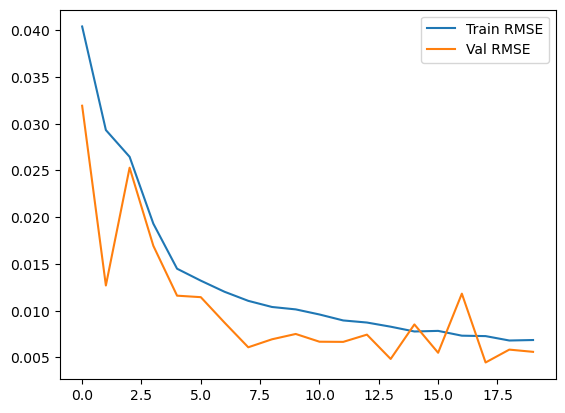

In [18]:
plt.plot(train_losses, label='Train RMSE')
plt.plot(val_losses, label='Val RMSE')
# plt.axvline(best_epoch, color='r', linestyle='--')
plt.legend()

In [19]:
torch.save(model.state_dict(), 'Unet_APE_model.pth')